In [ ]:
# Imports
import numpy as np 
import matplotlib.pyplot as plt
# registers 3‑D projection
from mpl_toolkits.mplot3d import Axes3D   
from math import sqrt, log, exp, erf
from scipy.stats import norm
# Root finder function from scipy.optimize
from scipy.optimize import least_squares,brentq
# Interpolator 
from scipy.interpolate import RegularGridInterpolator

# Black-Scholes Pricing tools


In [3]:
def bs_call_price(S0, K, r, T, sigma):
    """
    Black-Scholes European call price.
    """
    if T <= 0 or sigma <= 0:
        return max(S0 - K*np.exp(-r*T), 0.0)
    sqrtT = np.sqrt(T)
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T) / (sigma*sqrtT)
    d2 = d1 - sigma*sqrtT
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def bs_leading_term(S0, K, r, T, intvar):
    """
    Leading-order (ρ=0) Black–Scholes formula with total variance = intvar:
      d1 = [ln(S0/K) + rT + ½ intvar] / sqrt(intvar),
      d2 = d1 - sqrt(intvar),
      g0 = S0 N(d1) - K e^{-rT} N(d2).
    
    """
    
    sqrt_var = np.sqrt(intvar)
    d1 = (np.log(S0/K) + r*T + 0.5*intvar) / sqrt_var
    d2 = d1 - sqrt_var
    g0 = S0 * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    return g0, d1, d2


def BS_delta(S0, K, r, T, sigma):
    """
    Computes the implied Black–Scholes delta of a European call given:
      S0       : spot price
      K        : strike
      r        : risk-free rate
      T        : time to maturity
      sigma    : volatility
    
    Return delta = N(d1)
    """
    # handle zero or negative maturity
    if T <= 0 or sigma is None or sigma <= 0:
        return float(S0 > K)  # intrinsic delta for immediate expiry
    # compute d1 and delta
    sqrtT = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    return norm.cdf(d1)


def BS_vega(S0, K, r, T, sigma):
    """
    Computes the Black–Scholes Vega of a European call:
      
      S0     : spot price
      K      : strike
      r      : risk-free rate
      T      : time to maturity
      sigma  : volatility
    
    Returns ∂C/∂σ = S0 * sqrt(T) * φ(d1), where
      d1 = [ln(S0/K) + (r + 0.5 σ²) T] / (σ sqrt(T))
      φ = standard normal PDF
    """
    # handle zero or negative maturity (or non-positive sigma)
    if T <= 0 or sigma is None or sigma <= 0:
        return 0.0

    sqrtT = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    vega = S0 * sqrtT * norm.pdf(d1)
    return vega



# Heston Pricing Tools



In [4]:
def I1(v0, kappa, sigma, T):
    """
    First contribution to Var[∫₀ᵀ v_s ds] under Heston/CIR, as derived step-by-step:
      I1 = (2 σ² v0 / κ³) * [1 − e^(−κ T)(1+κ T) − (1/2)(1-e^(− κ T))^2]
    """
    return 2 * sigma**2 * v0 / kappa**3 * (
        1
        - np.exp(-kappa * T)*(1+kappa*T)
        - (1/2)*(1-np.exp(-kappa * T))**2
    )

def I2(theta, kappa, sigma, T):
    """
    Second contribution to Var[∫₀ᵀ v_s ds] under Heston/CIR:
      I2 = (σ² θ / κ³) * [κ T − 5/2 + ½(e^(−2 κ T))+2 e^(− κ T)(1+κ T)]
    """
    e = np.exp(-kappa * T)
    return sigma**2 * theta / kappa**3 * (
        kappa * T - (5/2) +(1/2)*(np.exp(-2*kappa*T))
        + 2 * e * (1+kappa*T)
        
    )

def integrated_variance_mean(a, b, v0, T):
    """
    Mean of the integrated variance under Heston:
      E[ ∫_0^T v_t dt ] = a*T + (v0 - a)/b * (1 - exp(-b*T))
    
    """
    return a*T + ((v0 - a)/b) * (1 - np.exp(-b*T))

def var_integrated_variance(theta, kappa, sigma, v0, T):
    """
     Variance of the time‐integrated variance:
       Var[∫0^T v_s ds] = I1 + I2
    """
    return I1(v0, kappa, sigma, T) + I2(theta, kappa, sigma, T)


def heston_price_approx(S0, K, r, T, v0, a, b, c, rho): 
    """
    Two‐term Heston call‐price approximation:
      C ≈ g0_tilde + ρ * g1_bar

    Parameters
    ----------
    S0    : float  Initial spot price.
    K     : float  Strike price.
    r     : float  Risk‐free rate.
    T     : float  Time to maturity.
    v0    : float  Initial variance 
    a     : float  Long‐run variance (θ).
    b     : float  Mean‐reversion speed (κ).
    c     : float  Vol‐of‐vol (σ).
    rho   : float  Correlation ρ between price & variance Brownian motions.

    Returns
    -------
    C_approx : float  ≈ g0_tilde + ρ g1_bar
    g0_tilde : float  Zeroth‐order term with variance‐of‐variance correction
    g1_bar   : float  First‐order correlation correction
    """
    if T <= 0:
        payoff = max(S0 - K, 0.0)
        return payoff, payoff, 0.0

    # 1) Mean integrated variance E[∫v]
    intvar = integrated_variance_mean(a, b, v0, T)
    if intvar < 1e-12:
        payoff = max(S0 - K*np.exp(-r*T), 0.0)
        return payoff, payoff, 0.0

    # 2) bar‐g0 and bar‐g1 as before
    g0_bar, d1, d2 = bs_leading_term(S0, K, r, T, intvar)
    
    
    bracket = (v0 - 2*a)/b * (1 - np.exp(-b*T)) \
            + T * (a - (v0 - a)*np.exp(-b*T))
    g1_bar = -c * K * np.exp(-r*T) * d2 * norm.pdf(d2) * bracket \
             / ( 2*b*intvar)

    # 3) Correct Var[∫v] under Heston
    var_intvar = var_integrated_variance(a, b, c, v0, T)

    # 4) g0_tilde correction per paper (page 25/35):
    #    = (K e^{-rT})/(8⋅intvar^{3/2}) ⋅ (d2 d1 - 1) φ(d2) ⋅ Var[intvar]
    corr = (
        K * np.exp(-r*T)
        * (d2*d1 - 1)
        * norm.pdf(d2)
        * var_intvar
        / (8 * intvar**1.5)
    )
    g0_tilde = g0_bar + corr
    

    # 5) final price
    C_approx = g0_tilde + rho * g1_bar
    return max(C_approx,0), g0_tilde, g1_bar 

def heston_implied_v0(C_mkt, S0, K, r, T, v0, a, b, c, rho,
                      vol_lower=1e-6, vol_upper=5.0, tol=1e-8):
    """
    Corrected inversion for implied initial variance v0 using the two-term Heston approximation:
      C ≈ g0_tilde + ρ g1_bar

    - Extracts price from heston_price_approx return tuple
    - Clamps C_mkt between intrinsic+eps and S0-eps to ensure a valid bracket
    - Returns np.nan if Brent's method fails to bracket or converge
    """
    # Compute intrinsic value for a call (discounted)
    intrinsic = max(S0 - K * np.exp(-r * T), 0)
    eps = 1e-8
    # Clamp the market price to (intrinsic + eps, S0 - eps)
    C_clamped = min(max(C_mkt, intrinsic + eps), S0 - eps)

    # Root function: difference between model price and clamped market price
    f = lambda sig: heston_price_approx(S0, K, r, T, sig, a, b, c, rho)[0] - C_clamped

    try:
        # Brent's method in [vol_lower, vol_upper]
        return brentq(f, vol_lower, vol_upper, xtol=tol, maxiter=200)
    except ValueError:
        return np.nan

# Volatility helper functions

In [5]:
def bs_implied_volatility(C_mkt, S, K, r, T,
                       vol_lower=1e-6, vol_upper=5.0,
                       tol=1e-8):
    """
    Invert BS for implied vol with robust preprocessing:
      - clamp C_mkt to (intrinsic + eps, S - eps)
      - bracket search on [vol_lower, vol_upper]
      - returns np.nan if it truly fails.
    """
    # 1) No‐arb bounds
    intrinsic = np.maximum(S - K*np.exp(-r*T), 0.0)
    forward   = S  # max call price before paying strike
    eps_price = 1e-5

    # clamp into (intrinsic + eps, forward - eps)
    C_clamped = min(max(C_mkt, intrinsic + eps_price),
                    forward   - eps_price)

    # 2) Define root function
    f = lambda sig: bs_call_price(S, K, r, T, sig) - C_clamped

    # 3) Try bracketed Brent
    try:
        return brentq(f, vol_lower, vol_upper, xtol=tol, maxiter=200)
    except ValueError:
        # failed to bracket → give up
        return np.nan
    
    
def compute_iv_surface(S0, r, v0, K_vals, T_vals):
    """
    Function to compute Implied volatility surface from market data. 
    """
    price_matrix = np.zeros((len(T_vals), len(K_vals)))
    iv_matrix    = np.zeros_like(price_matrix)
    
    for i, T in enumerate(T_vals):
        # choose Heston params by maturity
        if T <= 0.2:
            a, b, c, rho = 0.025, 1.62, 0.44, -0.76
        else:
            a, b, c, rho = 0.035, 1.15, 0.39, -0.64
        
        for j, K in enumerate(K_vals):
            price = heston_price_approx(S0, K, r, T, v0, a, b, c, rho)[0]
            price_matrix[i, j] = price
            iv_matrix[i, j] = bs_implied_volatility(price, S0, K, r, T)
    
    return price_matrix, iv_matrix


def plot_iv_surface(K_vals, T_vals, iv_matrix):
    """
    3D surface plot of implied vol vs strike & maturity.
    """
    T_grid, K_grid = np.meshgrid(T_vals, K_vals, indexing='ij')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(T_grid, K_grid, iv_matrix, cmap='viridis')
    ax.set_xlabel('Maturity T')
    ax.set_ylabel('Strike K')
    ax.set_zlabel('Implied Volatility')
    fig.colorbar(surf, ax=ax, shrink=0.5, label='Vol')
    plt.tight_layout()
    plt.show()


def compute_realized_vol(t, v_path):
    """
    Given time grid t (shape N) and variance path v_path (shape N),
    return realized volatility up to each t[i]:
       RV[i] = sqrt( (1/t[i]) * ∫_0^{t[i]} v_s ds ).
    We approximate the integral by a simple rectangle rule.
    """
    # cumulative integral of v: ∫_0^{t[i]} v_s ds ≈ Σ v[j]*Δt
    dt = t[1] - t[0]
    cum_int = np.cumsum(v_path) * dt
    # avoid division by zero at t[0]
    realized_vol = np.empty_like(v_path)
    realized_vol[0] = np.sqrt(v_path[0])  # just fallback to instantaneous at t=0
    # for i>0 use the definition
    realized_vol[1:] = np.sqrt(cum_int[1:] / t[1:])
    return realized_vol

# Verifying the Heston prices from Antonelli Paper. 

In [6]:
# Example parameters from the paper
S0    = 100.0    # spot price
K     = 110       # strike
r     = 0.05     # risk‐free rate
T     = 0.8      # time to maturity
v0    = 0.2      # initial variance 
a     = 0.035    # long‐run variance (θ)
b     = 1.15     # mean‐reversion speed (κ)
c     = 0.39     # volatility of variance (σ)
rho   = -0.64    # correlation

price, g0, g1 = heston_price_approx(S0, K, r, T, v0, a, b, c, rho)
print(f"Approximate Heston call price C ≈ g0 + ρ g1 = {price:.4f}")
print(f" g0 (ρ=0 term) = {g0:.4f}")
print(f" g1 (first‐order corr. term) = {g1:.4f}")
print(f"BS leading term approximation; {bs_leading_term(S0,K,r,T,integrated_variance_mean(a, b, v0, T))[0]}")

print(f"BS call price; {bs_call_price(S0,K,r,T,sqrt(v0))}")






Approximate Heston call price C ≈ g0 + ρ g1 = 10.3052
 g0 (ρ=0 term) = 10.8519
 g1 (first‐order corr. term) = 0.8542
BS leading term approximation; 11.144359917652686
BS call price; 13.612753842408893


# Simulation tools


In [7]:
def simulate_heston_physical(S0, v0, r, kappa, theta, sigma, rho, T, N_steps, N_paths):
    """
    Simulate Heston model paths using Euler-Maruyama with full truncation. Note that v represents the variance. 
    
    dS_t = r S_t dt + sqrt(v_t) S_t dW1_t
    dv_t = kappa (theta - v_t) dt + sigma sqrt(v_t) dW2_t
    corr(dW1, dW2) = rho
    
    Returns:
      t       : array of times of length N_steps+1
      S_paths : (N_steps+1, N_paths) array of simulated stock prices
      v_paths : (N_steps+1, N_paths) array of simulated variances
    """
    dt = T / N_steps
    t = np.linspace(0, T, N_steps + 1)
    
    # Arrays to store paths
    S_paths = np.zeros((N_steps + 1, N_paths))
    v_paths = np.zeros((N_steps + 1, N_paths))
    S_paths[0, :] = S0
    v_paths[0, :] = v0
    
    # Simulate increments
    for i in range(N_steps):
        # Correlated Brownian increments
        Z_v = np.random.randn(N_paths)
        Z_indep = np.random.randn(N_paths)
        dW_v = np.sqrt(dt) * Z_v
        dW_s = rho * dW_v + np.sqrt(1 - rho**2) * np.sqrt(dt) * Z_indep
        
        v_prev = v_paths[i, :]
        v_pos = np.maximum(v_prev, 0)
        if T-i*dt <= 0.2:
            # short‐term
            kappa, theta, sigma, rho = 0.025, 1.62, 0.44, -0.76
        else:
            # medium/long‐term
            kappa, theta, sigma, rho = 0.035, 1.15, 0.39, -0.64
        # Variance update (full truncation), ensuring variance remains positive
        dv = kappa * (theta - v_pos) * dt + sigma * np.sqrt(v_pos) * dW_v
        v_new = np.maximum(v_prev + dv, 0)
        
        # Stock price update
        dS = (r - 0.5 * v_pos) * dt + np.sqrt(v_pos) * dW_s
        S_new = S_paths[i, :] * np.exp(dS)
        
        S_paths[i+1, :] = S_new
        v_paths[i+1, :] = v_new
    
    return t, S_paths, v_paths

In [ ]:
def simulate_bs_physical(S0, r, sigma, T, N_steps, N_paths):
    """
    Simulate geometric Brownian motion (Black-Scholes) paths. Using Euler-Maruyama method:

    dS_t = r S_t dt + sigma S_t dW_t

    Parameters
    ----------
    S0 : float
        Initial stock price.
    r : float
        Risk-free rate.
    sigma : float
        Volatility.
    T : float
        Time horizon.
    N_steps : int
        Number of time steps.
    N_paths : int
        Number of simulated paths.

    Returns
    -------
    t : ndarray, shape (N_steps+1,)
        Time grid.
    S_paths : ndarray, shape (N_steps+1, N_paths)
        Simulated stock price paths.
    """
    dt = T / N_steps
    t = np.linspace(0, T, N_steps + 1)
    S_paths = np.zeros((N_steps + 1, N_paths))
    S_paths[0, :] = S0

    # Generate Brownian increments
    Z = np.random.randn(N_steps, N_paths)
    dW = np.sqrt(dt) * Z

    for i in range(N_steps):
        drift = (r - 0.5 * sigma**2) * dt
        diffusion = sigma * dW[i]
        S_paths[i + 1, :] = S_paths[i, :] * np.exp(drift + diffusion)

    return t, S_paths

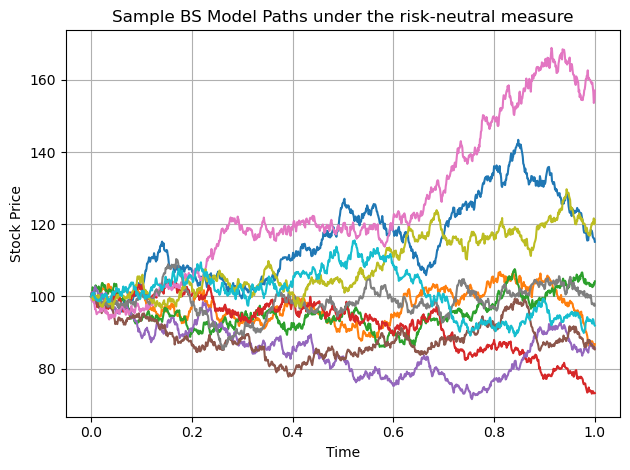

In [9]:
S0, v0 = 100.0, 0.04
r = 0.05
sigma = 0.2
T = 1.0
N_steps = 1000
N_paths = 10

t, S_paths = simulate_bs_physical(S0, r, sigma, T, N_steps, N_paths)
# Plot a few sample paths
plt.figure()
plt.grid(True)
for j in range(N_paths):
    plt.plot(t, S_paths[:, j])
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Sample BS Model Paths under the risk-neutral measure")
plt.tight_layout()
plt.show()

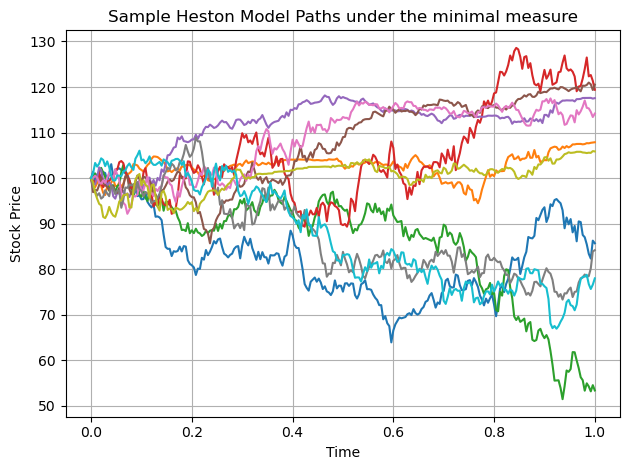

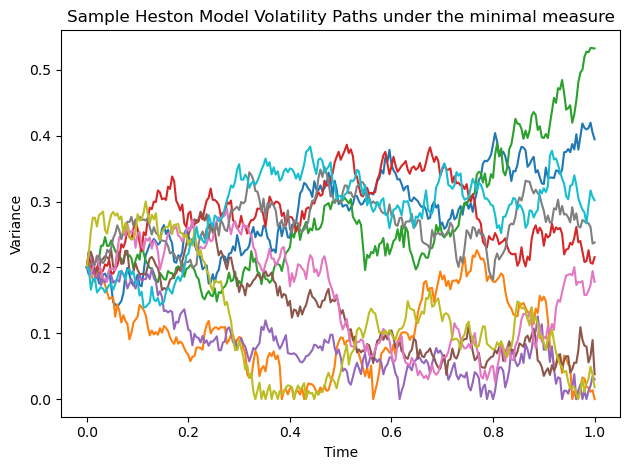

In [11]:
# Parameters
S0, v0 = 100.0, 0.04
r = 0.0
kappa, theta, sigma, rho = 1.5, 0.04, 0.3, -0.7
T = 1.0
N_steps = 250
N_paths = 10

# Simulate
t, S_paths, v_paths = simulate_heston_physical(S0, v0, r, kappa, theta, sigma, rho, T, N_steps, N_paths)

# Plot a few sample paths
plt.figure()
plt.grid(True)
for j in range(N_paths):
    plt.plot(t, S_paths[:, j])
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Sample Heston Model Paths under the minimal measure")
plt.tight_layout()
plt.show()
# Plot volatility paths
for j in range(N_paths):
    plt.plot(t, np.sqrt(v_paths[:, j]))

plt.xlabel("Time")
plt.ylabel("Variance")
plt.title("Sample Heston Model Volatility Paths under the minimal measure")
plt.tight_layout()

# Plotting 1 ATM Call Evolution during Heston

In [20]:
def simulate_call_price_evolution(
    S0, v0, r, kappa, theta, sigma,
    T, N_steps,
    K=None,
    N_paths=1
):
    """
    Simulate the evolution of an ATM call price under the Heston model.
    
    This runs an Euler-Maruyama + full-truncation on (S_t,v_t), then
    at each time step prices the call via your heston_price_approx.
    
    Parameters
    ----------
    S0 : float
        Initial spot price.
    v0 : float
        Initial variance.
    r : float
        Risk-free rate (annual).
    kappa : float
        Variance mean-reversion speed.
    theta : float
        Long-run variance.
    sigma : float
        Volatility of variance ("vol-of-vol").
    T : float
        Total maturity (in years).
    N_steps : int
        Number of time steps.
    K : float, optional
        Strike.  Defaults to ATM = S0.
    N_paths : int, optional
        Number of Monte-Carlo paths.  Defaults to 1.
    
    Returns
    -------
    t : ndarray, shape (N_steps+1,)
        Time grid from 0 to T.
    call_prices : ndarray, shape (N_steps+1, N_paths)
        ATM call price at each t for each path.
    S_paths : ndarray, shape (N_steps+1, N_paths)
        Simulated spot paths.
    v_paths : ndarray, shape (N_steps+1, N_paths)
        Simulated variance paths.
    """
    # If no strike given, use ATM
    if K is None:
        K = S0

    # choose a,b,c,rho by term
    if T <= 0.2:
        # short‐term
        a, b, c, rho = 0.025, 1.62, 0.44, -0.76
    else:
        # medium/long‐term
        a, b, c, rho = 0.035, 1.15, 0.39, -0.64

    # simulate Heston
    t, S_paths, v_paths = simulate_heston_physical(
        S0, v0, r, kappa, theta, sigma, rho,
        T, N_steps, N_paths
    )
    
    # allocate price array
    call_prices = np.zeros_like(S_paths)
    
    # price each time & path
    for i, ti in enumerate(t):
        tau = T - ti
        for j in range(N_paths):
            if tau <= 0.2:
                # short‐term
                a, b, c, rho = 0.025, 1.62, 0.44, -0.76
            else:
                # medium/long‐term
                a, b, c, rho = 0.035, 1.15, 0.39, -0.64
            call_prices[i, j] = heston_price_approx(
                S_paths[i, j], K, r, tau,
                v_paths[i, j], a, b, c, rho
            )[0]

    return t, call_prices, S_paths, v_paths

In [21]:
def plot_implied_vol_evolution(
    S0, v0, r, kappa, theta, sigma,
    T, N_steps,
    K=None,
    N_paths=1,
    path_idx=0,
    vol_lower=1e-6,
    vol_upper=5.0,
    tol=1e-8
):
    """
    Simulate an ATM call under Heston and plot its implied volatility over time.

    Parameters
    ----------
    S0 : float
        Initial spot price.
    v0 : float
        Initial variance.
    r : float
        Risk-free rate (annual).
    kappa : float
        Variance mean-reversion speed.
    theta : float
        Long-run variance.
    sigma : float
        Volatility of variance.
    T : float
        Total maturity (in years).
    N_steps : int
        Number of time steps.
    K : float, optional
        Strike. Defaults to ATM = S0.
    N_paths : int, optional
        Number of Monte‐Carlo paths. Defaults to 1.
    path_idx : int, optional
        Which path index to plot (0 ≤ path_idx < N_paths).
    vol_lower, vol_upper, tol : float, optional
        Bounds and tolerance for implied volatility solver.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The figure object (call `plt.show()` if running non-interactively).
    true_paths:
        The array of actual generating variance paths from heston
    iv:
        The implied volatility array from the call prices
    
    """
    # Default ATM strike
    if K is None:
        K = S0

    # 1) Simulate prices & variances
    t, call_prices, S_paths, v_paths = simulate_call_price_evolution(
        S0, v0, r, kappa, theta, sigma,
        T, N_steps,
        K=K,
        N_paths=N_paths
    )

    # 2) Compute implied vols along the chosen path
    iv = np.full_like(t, np.nan)
    for i, ti in enumerate(t):
        tau = T - ti
        C = call_prices[i, path_idx]
        S = S_paths[i, path_idx]
        # skip tau near zero
        if tau > 0:
            iv[i] = bs_implied_volatility(
                C, S, K, r, tau,
                vol_lower=vol_lower,
                vol_upper=vol_upper,
                tol=tol
            )

    # 3) Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(t, iv, label=f'Implied Vol Path #{path_idx}')
    ax.plot(t,np.sqrt(v_paths),label='Actual heston instantaneous vol')
    ax.set_xlabel("Time $t$ (years)")
    ax.set_ylabel("Implied volatility")
    ax.set_title("Evolution of ATM implied vol under Heston")
    ax.grid(True)
    ax.legend()

    return fig, v_paths,iv

In [22]:
def vol_sq_error(t, Y_hat, Y):
    """
    Compute ∫₀ᵀ [Y_hat(t)² – Y(t)²] dt via trapezoidal rule,
    dropping any NaN entries and returning a Python float.

    Parameters
    ----------
    t : array_like, shape (N,)
        Time grid from 0 to T.
    Y_hat : array_like, shape (N,) or (N,1)
        Implied vol estimate.
    Y : array_like, shape (N,) or (N,1)
        True instantaneous vol (e.g. sqrt(v_t)).

    Returns
    -------
    error : float
        The integral ∫[Y_hat² – Y²] dt.
    """
    # flatten to 1D
    t      = np.asarray(t).ravel()
    Y_hat  = np.asarray(Y_hat).ravel()
    Y      = np.asarray(Y).ravel()

    if t.shape != Y_hat.shape or t.shape != Y.shape:
        raise ValueError(f"All inputs must be same length: got {t.shape}, {Y_hat.shape}, {Y.shape}")

    # drop any NaNs
    mask = (~np.isnan(Y_hat)) & (~np.isnan(Y))
    if mask.sum() < 2:
        # not enough points to integrate
        return 0.0

    diff_sq = Y_hat[mask]**2 - Y[mask]**2
    val = np.trapz(diff_sq, t[mask])
    return float(val)

In [23]:
def plot_vol_sq_error_distribution(
    S0, v0, r, kappa, theta, sigma,
    T, N_steps,
    K=None,
    M=100,
    vol_lower=1e-6,
    vol_upper=5.0,
    tol=1e-8,
    bins=30
):
    """
    Simulate M independent Heston paths, compute ∫(Yhat² - Y²) dt for each,
    and plot the histogram of these errors.

    Parameters
    ----------
    S0, v0, r, kappa, theta, sigma, T, N_steps : as before
    K : float, optional
        Strike (defaults to ATM = S0).
    M : int
        Number of Monte Carlo experiments.
    vol_lower, vol_upper, tol : float
        implied_volatility() parameters.
    bins : int
        Number of histogram bins.

    Returns
    -------
    fig : matplotlib.figure.Figure
        The histogram figure.
    errors : ndarray, shape (M,)
        The array of ∫(Yhat²−Y²) dt for each simulation.
    """
    if K is None:
        K = S0

    # 1) Simulate everything in one batch
    #    (this gives us M independent S_t, v_t and call prices)
    t, call_prices, S_paths, v_paths = simulate_call_price_evolution(
        S0, v0, r, kappa, theta, sigma,
        T, N_steps,
        K=K,
        N_paths=M
    )

    # 2) For each j=0..M-1 compute implied-vol curve and error
    errors = np.zeros(M)
    for j in range(M):
        # compute iv_j(t_i) by inverting the call price at each time
        iv_j = np.empty_like(t)
        for i, ti in enumerate(t):
            tau = T - ti
            C = call_prices[i, j]
            S = S_paths[i, j]
            iv_j[i] = bs_implied_volatility(
                C, S, K, r, tau,
                vol_lower=vol_lower,
                vol_upper=vol_upper,
                tol=tol
            )
        # true instantaneous vol Y_j = sqrt(v_paths[:,j])
        Y   = np.sqrt(v_paths[:, j])
        # error = ∫(iv_j² - Y²) dt
        errors[j] = vol_sq_error(t, iv_j, Y)

    # 3) Plot histogram
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(errors, bins=bins)
    ax.set_xlabel("int_0^T(\hat Y^2 - Y^2)\,dt")
    ax.set_ylabel("Frequency")
    ax.set_title(f"Distribution of vol²‐error over {M:,} sims")
    ax.grid(True)

    return fig, errors

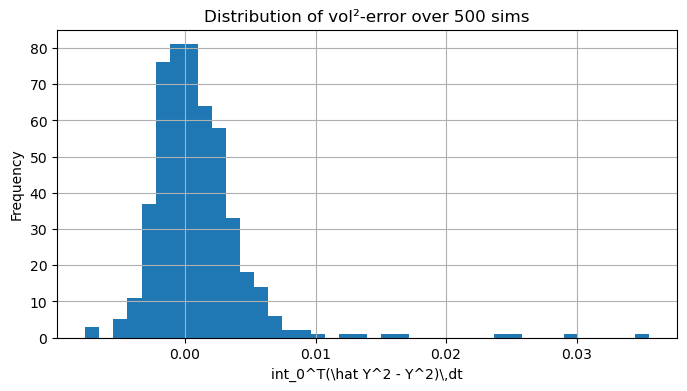

mean error: 0.0009354491136689747
std  error: 0.0038222824157974943
5% / 95% quantiles: [-0.00306533  0.00578319]


In [47]:
fig, errors = plot_vol_sq_error_distribution(
    S0=100, v0=0.04, r=0.05,
    kappa=1.5, theta=0.04, sigma=0.3,
    T=0.25, N_steps=250,
    M=500,         # run 500 Monte Carlo experiments
    bins=40
)
plt.show()

# Now you have `errors`, e.g.:
print("mean error:", np.mean(errors))
print("std  error:", np.std(errors))
print("5% / 95% quantiles:", np.percentile(errors, [5,95]))

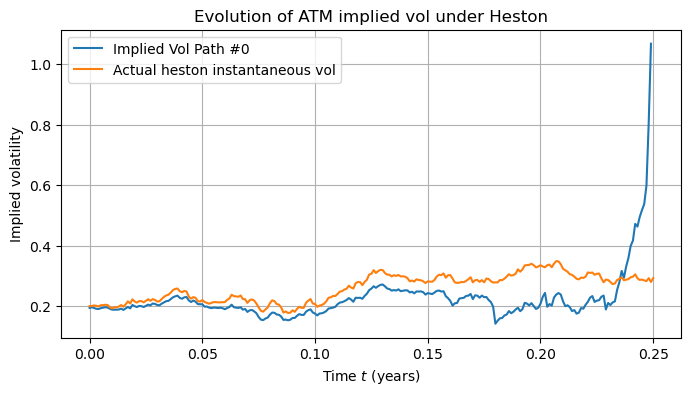

In [48]:
S0, v0, r = 100.0, 0.04, 0.05
kappa, theta, sigma = 1.5, 0.04, 0.3
T, N_steps = 0.25, 250

# this will pop up a matplotlib window (or inline plot in a notebook)
fig, true_v, implied_v = plot_implied_vol_evolution(
    S0, v0, r, kappa, theta, sigma,
    T, N_steps
)
plt.show()

# Plotting "Market" data generated by Heston

In [24]:
def plot_heston_surface(S0, r, v0, K_vals, T_vals):
    """
    Note this function is giving us our generated "market" data
    """
    price_matrix = np.zeros((len(T_vals), len(K_vals)))

    for i, T in enumerate(T_vals):
        # Choose parameters based on maturity
        if T <= 0.2:
            a, b, c, rho = 0.025, 1.62, 0.44, -0.76
        else:
            a, b, c, rho = 0.035, 1.15, 0.39, -0.64

        for j, K in enumerate(K_vals):
            price, _, _ = heston_price_approx(S0, K, r, T, v0, a, b, c, rho)
            price_matrix[i, j] = price

    # Create meshgrid for plotting
    T_grid, K_grid = np.meshgrid(T_vals, K_vals, indexing='ij')

    # Plot surface
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')
#     ax.plot_surface(T_grid, K_grid, price_matrix)
#     ax.set_xlabel('Maturity T')
#     ax.set_ylabel('Strike K')
#     ax.set_zlabel('Call Price')
#     plt.tight_layout()
#     plt.show()
    return price_matrix

In [25]:
def calibrate_heston_slice(K_vals,T_vals,market_prices, S0, r, init_theta, bounds):
    """
    Calibrate full tuple [a, b, c, rho, v0] across a cross-section of quotes.

    Args:
        market_prices (array-like): Flattened array of observed option prices
            for strikes K_vals and maturities T_vals (defined in the calling scope).
        S0 (float): Initial spot price.
        r (float): Risk-free rate.
        init_theta (array-like): Initial guess [a, b, c, rho, v0].
        bounds (2-tuple of array-like): (lower_bounds, upper_bounds) for each parameter.

    Returns:
        ndarray: Calibrated Heston parameters [a, b, c, rho, v0].
    """
    # NOTE: this function assumes that the arrays K_vals and T_vals
    # are defined in the global scope, and market_prices corresponds
    # to np.repeat(T_vals, len(K_vals)) × np.tile(K_vals, len(T_vals)).
    strikes    = np.tile(K_vals, len(T_vals))
    maturities = np.repeat(T_vals, len(K_vals))

    def residuals(theta):
        a, b, c, rho, v0 = theta
        model_prices = np.array([
            heston_price_approx(S0, K, r, T, v0, a, b, c, rho)[0]
            for K, T in zip(strikes, maturities)
        ])
        return model_prices - market_prices

    res = least_squares(residuals, init_theta, bounds=bounds, method='trf')
    return res.x

In [14]:
# Market‐generation settings
S0, r = 100.0, 0.05
true_v0 = 0.05
K_vals = np.linspace(80, 120, 9)
T_vals = np.array([0.1, 0.2, 0.5, 1.0, 2.0])

# (a) Generate synthetic "market" surface
price_matrix = plot_heston_surface(S0, r, true_v0, K_vals, T_vals)

# (b) Flatten for calibration
market_prices = price_matrix.ravel()

# (c) Calibrate full slice (Approach 1)
init_theta = [0.03, 1.0, 0.3, -0.5, 0.04]  # [a, b, c, rho, v0]
bounds = ([1e-3, 0.1, 1e-3, -0.999, 1e-3], [1.0, 10.0, 5.0, 0.999, 1.0])
cal_params = calibrate_heston_slice(K_vals, T_vals, market_prices, S0, r,
                                    init_theta, bounds)
print("Calibrated parameters [a, b, c, rho, v0]:", cal_params)

# (d) Implied v0 for a single strike/maturity (Approach 2)
K_single, T_single = 100, 1.0
# locate the corresponding market price
i = np.where(T_vals == T_single)[0][0]
j = np.argmin(np.abs(K_vals - K_single))
C_mkt_single = price_matrix[i, j]

imp_v0 = heston_implied_v0(
    C_mkt_single, S0, K_single, r, T_single,
    cal_params[4],  # initial v0 guess
    cal_params[0],  # a
    cal_params[1],  # b
    cal_params[2],  # c
    cal_params[3]   # rho
)
print("Implied v0 for single quote:", imp_v0)

Calibrated parameters [a, b, c, rho, v0]: [ 0.03521815  1.13530519  0.37856952 -0.66503786  0.04904709]
Implied v0 for single quote: 0.04919738242511219


In [15]:
def build_iv_interpolator(K_vals, T_vals, iv_surface):
    """
    Returns a function iv_interp((T, K)) that linearly interpolates
    the implied vol surface defined on the grid (T_vals, K_vals).
    """
    return RegularGridInterpolator((T_vals, K_vals), iv_surface, bounds_error=False, fill_value=None)

def bs_call_delta(S0, K, r, T, iv_interp):
    """
    Computes the implied Black–Scholes delta of a European call given:
      S0       : spot price
      K        : strike
      r        : risk-free rate
      T        : time to maturity
      iv_interp: interpolator for implied vol surface
    
    Steps:
      1. Interpolate sigma_impl = iv_interp((T, K))
      2. Compute d1 = [ln(S0/K) + (r + 0.5*sigma^2)T] / (sigma*√T)
      3. Return delta = N(d1)
    """
    # 1) implied vol from surface
    sigma = iv_interp((T, K))
    # 2) handle zero or negative maturity
    if T <= 0 or sigma is None or sigma <= 0:
        return float(S0 > K)  # intrinsic delta for immediate expiry
    # 3) compute d1 and delta
    sqrtT = np.sqrt(T)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrtT)
    return norm.cdf(d1)

In [26]:
def heston_delta_approx(S0, K, r, T, v0, a, b, c, rho):
    """
    Function to compute the heston Delta of a European call option
    using the two-term approximation:
      Δ ≈ g0' + ρ g1'
    """
    
    intvar = integrated_variance_mean(a, b, v0, T)
    _, d1, d2 = bs_leading_term(S0, K, r, T, intvar)

    dg0_dx = S0 * norm.cdf(d1)

    # --- same bracket as above ---
    bracket = (
        (v0 - 2*a) / (b) * (1 - np.exp(-b*T))
        + T * (a - (v0 - a)*np.exp(-b*T))
    )
    gamma = bracket / (2*b * intvar)

    dg1_dx = -c * K * np.exp(-r*T) * gamma * (1 - d2**2) * norm.pdf(d2) / np.sqrt(intvar)

    delta = (dg0_dx + rho * dg1_dx) /S0
    return delta

In [30]:
def plot_calibrated_heston_tracking_error(K_vals, T_vals,
                        S0, r, init_theta, bounds,
                        strike, mat, true_params, n_steps, plot=False):
    """
    Generates market prices under the *true* Heston parameters (embedded
    in plot_heston_surface), calibrates a new parameter set from those
    prices, then simulates a call-price path under the true model and
    delta-hedges it using the *calibrated* parameters. Finally it plots
    the hedging tracking error over time.

    Args:
        K_vals (array-like): Strikes for calibration surface.
        T_vals (array-like): Maturities for calibration surface.
        S0 (float): Initial spot price.
        r (float): Risk-free rate.
        init_theta (array-like): Initial guess [a, b, c, rho, v0].
        bounds (2-tuple of array-like): Bounds for calibration.
        strike (float): Strike of the call to hedge.
        mat (float): Time to maturity of the call (years).
        true_params (array-like): True Heston parameters [kappa, theta, sigma, rho, v0].
        n_steps (int): Number of time-steps in the simulation.

    Returns:
        None  # Displays a matplotlib plot
    """
    # Unpack true parameters
    kappa_true, theta_true, sigma_true, rho_true, v0_true = true_params

    # 1) Generate “market” surface under true params embedded in function
    #    Signature: plot_heston_surface(S0, r, v0_true, K_vals, T_vals)
    market_surface = plot_heston_surface(S0, r, v0_true, K_vals, T_vals)
    market_prices  = market_surface.flatten()

    # 2) Calibrate using same grid
    #    Signature: calibrate_heston_slice(K_vals, T_vals, market_prices, S0, r, init_theta, bounds)
    calibrated = calibrate_heston_slice(
        K_vals, T_vals, market_prices,
        S0, r, init_theta, bounds
    )
    # We only calibrate the heston parameters once at the start. 
    a_c, b_c, c_c, rho_c, v0_c = calibrated

    # 3) Simulate one path under the true model, note true parameters are now also embedded in the function
    # t, call_prices, S_paths, v_paths
    #    Signature: simulate_call_price_evolution(S0, v0, r, kappa, theta, sigma,
    #                                            T, N_steps, K=None, N_paths=1)
    times, call_prices_true,spot_path,_ = simulate_call_price_evolution(
        S0, v0_true, r,
        kappa_true, theta_true, sigma_true,
        mat, n_steps,
        K=strike
    )

    # 4) Compute deltas using existing notebook function
    #    Signature: heston_delta_hedge(S, K, r, T_rem, v0, a, b, c, rho)
    deltas = [
        heston_delta_approx(
            spot_path[i],
            strike,
            r,
            mat - times[i],
            v0_c, a_c, b_c, c_c, rho_c
        )
        for i in range(len(spot_path) - 1)
    ]

    # 5) Build the hedged portfolio
    dt   = np.diff(times)
    cash = call_prices_true[0] - deltas[0] * spot_path[0]
    port = [cash + deltas[0] * spot_path[0]]

    for i in range(len(dt)):
        cash *= np.exp(r * dt[i])
        new_delta = deltas[i+1] if i+1 < len(deltas) else 0.0
        cash    -= (new_delta - deltas[i]) * spot_path[i+1]
        port.append(cash + new_delta * spot_path[i+1])

    # 6) Compute tracking error
    errors = np.array(port) - np.array(call_prices_true)

    # 7) Plot tracking error over time
    if plot==True:
        plt.figure(figsize=(8, 4))
        plt.plot(times, errors, label='Tracking Error')
        plt.xlabel("Time (years)")
        plt.ylabel("Hedged Portfolio – True Call Price")
        plt.title("Delta‐Hedge Tracking Error (Calibrated vs True Params)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    return times,errors


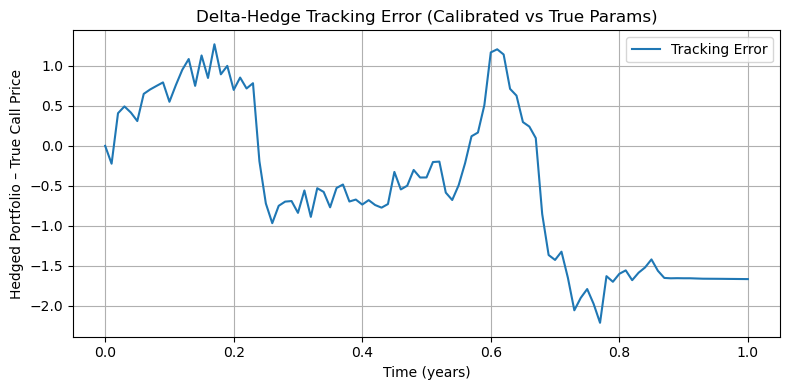

In [31]:
# 1) Define your calibration grid
K_vals = np.array([80, 90, 100, 110, 120])    # strikes for surface
T_vals = np.array([0.25, 0.5, 1.0, 2.0])      # maturities in years

# 2) Market/hedge settings
S0     = 100.0        # initial spot
r      = 0.05         # risk-free rate
init_theta = [1.0, 0.04, 0.5, -0.5, 0.04]  # starting guess for [a, b, c, rho, v0]
bounds     = (
    [0.01, 0.01, 0.01, -0.99, 0.01],  # lower bounds
    [5.0,  0.5,  2.0,  0.99,  1.0]    # upper bounds
)

# 3) The single call we want to hedge
strike      = 100.0    # ATM
mat         = 1.0      # 1 year to maturity

# 4) “True” Heston parameters used for both surface generation and path simulation
true_params = [2.0,   # a (kappa)
               0.05,  # b (theta)
               0.3,   # c (sigma)
              -0.7,   # rho
               0.05]  # v0

# 5) Number of time‐steps for the simulated path
n_steps = 100

# 6) Run the tracking‐error plot
times,errors = plot_calibrated_heston_tracking_error(
    K_vals, T_vals,
    S0, r, init_theta, bounds,
    strike, mat,
    true_params,
    n_steps,
    plot=True
)

In [ ]:
def plot_terminal_tracking_error_histogram(K_vals, T_vals,
                                           S0, r, init_theta, bounds,
                                           strike, mat, true_params,
                                           n_steps, n_runs=500, bins=50):
    """
    Runs `n_runs` independent singular calibration+hedge simulations
    (via `simulate_tracking_error`), collects the terminal tracking error
    from each, and plots a histogram of these terminal errors.

    Args:
        K_vals (array-like): Strikes for the calibration surface.
        T_vals (array-like): Maturities for the calibration surface.
        S0 (float): Initial spot price.
        r (float): Risk-free rate.
        init_theta (array-like): Initial guess [kappa, theta, sigma, rho, v0].
        bounds (2-tuple of array-like): Bounds for calibration.
        strike (float): Strike of the call to hedge.
        mat (float): Time to maturity of the call (years).
        true_params (array-like): True Heston parameters [kappa, theta, sigma, rho, v0].
        n_steps (int): Number of time‐steps in each simulation.
        n_runs (int): Number of Monte Carlo repetitions. Defaults to 500.
        bins (int): Number of histogram bins. Defaults to 50.

        
        
    Returns:
        None  # Displays a matplotlib histogram
    """
    terminal_errors = []
    for i in range(n_runs):
        times, errors = plot_calibrated_heston_tracking_error(
            K_vals, T_vals,
            S0, r, init_theta, bounds,
            strike, mat, true_params, n_steps,plot=False
        )
        terminal_errors.append(errors[-1])

    terminal_errors = np.array(terminal_errors)

    plt.figure(figsize=(8, 4))
    plt.hist(terminal_errors, bins=bins, edgecolor='black')
    plt.xlabel("Terminal Tracking Error")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Terminal Tracking Errors ({n_runs} simulations)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    print(f"mean={np.mean(terminal_errors)},standard deviation ={np.std(terminal_errors)}")

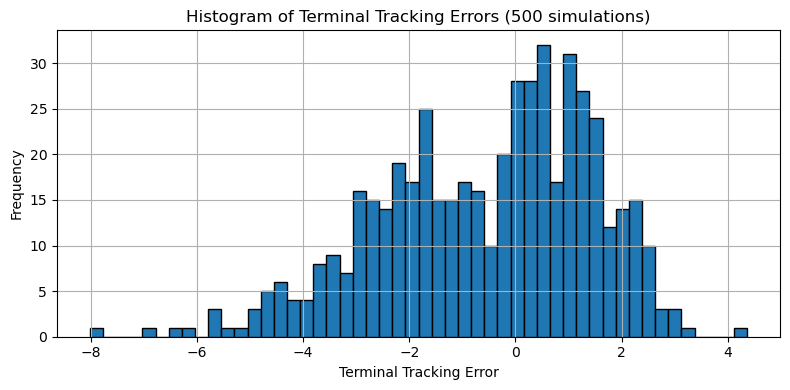

In [31]:
# Example Usage
plot_terminal_tracking_error_histogram(
    K_vals, T_vals,
    S0, r, init_theta, bounds,
    strike, mat, true_params,
    n_steps,
    n_runs=500,
    bins=50
)

In [75]:
def simulate_delta_hedged_portfolio(
    S0, v0, r, kappa, theta, sigma_v, rho,
    K, T, N_steps, BS_implied_vol, generatingModel="BS", Hedgingmodel="BS",
    dynamic=True
):
    """
    Simulate one path of:
      - S_t under Heston (using simulate_heston with N_paths=1)
      - A hedged portfolio: short 1 call, hedge with hedging model delta.

    Parameters
    ----------
    S0, v0, r : floats
        Initial spot, variance, and rate.
    kappa, theta, sigma_v, rho : floats
        Heston parameters.
    K : float
        Option strike.
    T : float
        Time to maturity.
    N_steps : int
        Number of time steps (uniform grid).
    BS_implied_vol : float
        The constant sigma used in BS delta hedging (from implied_volatility).
    generatingModel : string
        String representing which model we are assuming is the "True" generator. 
    Hedgingmodel : string
        String representing which model we are using to hedge, either BS or Heston. 
    dynamic : bool, default=True
        If True, rebalance Δ at every time step.
        If False, hold Δ(0) static.

    Returns
    -------
    t : ndarray, shape (N_steps+1,)
        Time grid points.
    S_path : ndarray, shape (N_steps+1,)
        Simulated stock path.
    delta_path : ndarray, shape (N_steps+1,)
        BS-delta holdings over time.
    cash_path : ndarray, shape (N_steps+1,)
        Cash (bank account) position over time.
    portfolio : ndarray, shape (N_steps+1,)
        Value of the hedging portfolio: Δ·S + cash.
        S0, v0, r, kappa, theta, sigma,
    T, N_steps,
    K=None,
    N_paths=1
    """
    # 1) Simulate one BS path
    if generatingModel == "BS":
        t,S_paths,_  = simulate_bs_physical(
            S0, r, sigma_v, 
            T=T, N_steps=N_steps, N_paths=1
        )
        call_prices = np.array([
            bs_call_price(S_paths[i], K, r, T - t[i], BS_implied_vol)
            for i in range(N_steps + 1)
        ])
        v_paths = np.zeros_like(S_paths)  # no variance path in BS model

    # 1) Simulate one Heston path which also corresponds to a call price path. 
    elif generatingModel == "Heston":
        t, call_prices, S_paths, v_paths = simulate_call_price_evolution(
            S0, v0, r, kappa, theta, sigma_v, 
            T=T, N_steps=N_steps, K=K, N_paths=1
        )
        
        # flatten call_prices to 1D if we only have one path
        call_prices = call_prices.squeeze()
    else:
        raise ValueError(f"Unknown generating model: {generatingModel}")
   
    S = S_paths[:, 0]
    dt = T / N_steps
    t = np.linspace(0, T, N_steps+1)

    # 2) Initial call and delta quantities
    if Hedgingmodel == "BS":
        # Initial BS quantities
        C0 = call_prices[0]
        BS_implied_vol = bs_implied_volatility(C0, S0, K, r, T,
                                                vol_lower=1e-6, vol_upper=5.0, tol=1e-8)
        delta0 = BS_delta(S0, K, r, T, BS_implied_vol)
        
    if Hedgingmodel == "Heston":
        # 2) Initial Heston quantities
        C0 = call_prices[0]  # from the simulated path
        delta0 = heston_delta_approx(S0, K, r, T, v0, theta, kappa, sigma_v, rho)


    # Cash after selling call and buying delta0 shares:
    cash0 = C0 - delta0 * S0

    # 3) Prepare output arrays
    delta_path = np.empty_like(S)
    cash_path = np.empty_like(S)
    portfolio = np.empty_like(S)

    delta_path[0] = delta0
    cash_path[0] = cash0
    portfolio[0] = delta0 * S0 + cash0

    # 4) Run through time grid
    for i in range(1, N_steps+1):
        # accrue interest on cash
        cash = cash_path[i-1] * np.exp(r * dt)

        # compute new delta
        if dynamic:
            T_remain = max(T - t[i], 0)

            if Hedgingmodel == "BS":
                delta_new = BS_delta(S[i], K, r, T_remain, BS_implied_vol)
            elif Hedgingmodel == "Heston": 
                delta_new = heston_delta_approx(S[i], K, r, T_remain, v_paths[i], theta, kappa, sigma_v, rho)
        else:
            delta_new = delta0

        # rebalancing: buy/sell shares costs ΔΔ * S[i]
        dD = delta_new - delta_path[i-1]
        cash -= dD * S[i]

        # record
        delta_path[i] = delta_new
        cash_path[i] = cash
        portfolio[i] = delta_new * S[i] + cash
    
        # If we generated the path under Heston, we can simply return the tracking error,call_price-portfolio. 
        # Note this tracking_error is when we statically hedge under heston only at the initial time. 
    tracking_error = call_prices - portfolio

    return t, S, delta_path, cash_path, v_paths, call_prices, portfolio, tracking_error
    
    

Mean terminal error : 1.767247
Std. dev.          : 3.651278


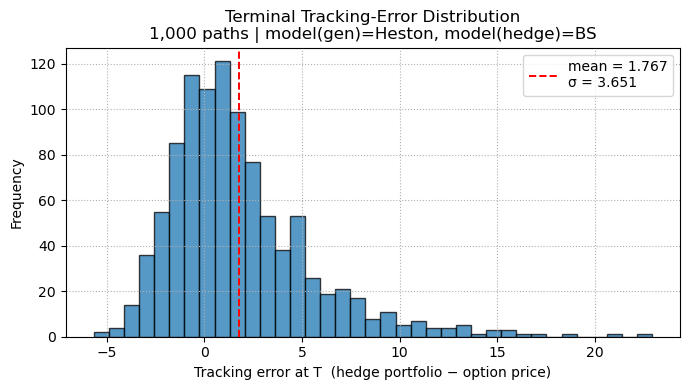

In [78]:
def plot_tracking_error_new(
    n_sims,
    S0, v0, r, kappa, theta, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    generatingModel="BS",
    Hedgingmodel="BS",
    dynamic=True,
    bins="auto",
    random_state=None,
    show_stats=True,
):
    """
    Monte-Carlo study of delta-hedging effectiveness.

    Parameters
    ----------
    n_sims : int
        Number of independent paths to simulate.
    All other arguments : see `simulate_delta_hedged_portfolio`.
    bins : int or str, default 'auto'
        Bin specification passed to `plt.hist`.
    random_state : int or None
        Seed for NumPy RNG; use for reproducibility.
    show_stats : bool
        If True, prints and annotates mean & stdev of the terminal errors.

    Returns
    -------
    terminal_errors : ndarray, shape (n_sims,)
        The portfolio-minus-option value at maturity for every simulation.
    """

    #rng = np.random.default_rng(random_state)
    terminal_errors = np.empty(n_sims)

    for j in range(n_sims):
        # ── simulate one hedged path ──────────────────────────
        t, S, _delta, _cash, _v,_call, _portfolio, _track_err = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol,
            generatingModel = generatingModel,
            Hedgingmodel = Hedgingmodel,
            dynamic=dynamic,
        )
        
        terminal_errors[j] = _track_err[-1]

    # ── plot empirical distribution ──────────────────────────
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.hist(terminal_errors, bins=bins, alpha=0.75, edgecolor="black")
    ax.set(
        title=f"Terminal Tracking-Error Distribution\n"
              f"{n_sims:,d} paths | "
              f"model(gen)={generatingModel}, model(hedge)={Hedgingmodel}",
        xlabel="Tracking error at T  (hedge portfolio − option price)",
        ylabel="Frequency",
    )
    ax.grid(True, ls=":")

    if show_stats:
        mu = terminal_errors.mean()
        sigma = terminal_errors.std(ddof=1)
        ax.axvline(mu, color="red", ls="--", lw=1.4,
                   label=f"mean = {mu:.4g}\nσ = {sigma:.4g}")
        ax.legend()
        print(f"Mean terminal error : {mu:.6f}")
        print(f"Std. dev.          : {sigma:.6f}")

    plt.tight_layout()
    plt.show()

    return terminal_errors

errs = plot_tracking_error_new(
    n_sims=1000,
    S0=100, v0=0.04, r=0.05,
    kappa=1.15, theta=0.035, sigma_v=0.39, rho=-0.64,
    K=100, T=1.0, N_steps=252,
    BS_implied_vol = 0.2,
    generatingModel="Heston",
    Hedgingmodel="BS",
    dynamic=True,
    random_state=42
)
# errs = plot_tracking_error_new(
#     n_sims=100,
#     S0=100, v0 = 0.2, r = 0.05,
#     kappa=1.15, theta=0.035, sigma_v=0.39, rho=-0.64,
#     K=100, T=1.0, N_steps=252,
#     BS_implied_vol = 0.2,
#     generatingModel="Heston",
#     Hedgingmodel="BS",
#     dynamic=False,
#     random_state=21
# )


In [33]:
def plot_delta_tracking_error_over_time(
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol, generatingModel="BS",hedgingModel = "BS",dynamic=True
):
    """
    Simulate one hedged portfolio path and plot the tracking error
    (portfolio - Heston("market") approximate price) over time.
    """
    # 1) Simulate one Heston path (N_paths=1)
    if generatingModel=="BS":
        t,S_paths = simulate_bs_physical(
            S0, r, sigma_v, 
            T=T, N_steps=N_steps, N_paths=1
        )
        S = S_paths[:, 0]
    
        v_paths = np.full_like(S_paths, v0)
        v       = v_paths[:, 0]
        
    else:
        t,S_paths, v_paths = simulate_heston_physical(
            S0, v0, r, kappa, theta, sigma_v, rho,
            T=T, N_steps=N_steps, N_paths=1
        )
        S = S_paths[:, 0]

        v = v_paths[:, 0]
        

    # 2) Simulate hedged portfolio on the same grid
    if hedgingModel=="BS":
        t_h, S_h, delta_path, cash_path, portfolio = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol, "BS",dynamic=dynamic
        )
    if hedgingModel=="Heston":
         t_h, S_h, delta_path, cash_path, portfolio = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol, "Heston",dynamic=dynamic
        )
        

    # 3) Compute Heston approximate call price at each time t_i
    call_price_path = np.array([
        heston_price_approx(
            S[i], K, r, T - t[i], v[i],
            theta, kappa, sigma_v, rho
        )[0]
        for i in range(len(t))
    ])
   
    implied_vol_path = np.array([
        bs_implied_volatility(call_price_path[i], S[i], K, r, T - t[i])
        for i in range(len(t))
    ])

    # 4) Tracking error: hedged portfolio minus call price
    tracking_error = portfolio - call_price_path

    # 5) Plot
    
    plt.figure(figsize=(8, 4))
    plt.plot(t, tracking_error, label='Tracking Error')
    plt.axhline(0, color='black', lw=0.8, ls='--')
    plt.xlabel('Time t')
    plt.ylabel('Portfolio Value − Heston Price')
    if dynamic:
        plt.title('Dynamic Hedging Tracking Error Over Time')
    else:
        plt.title('Hedging Tracking Error Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # Call
    
    
    plt.figure(figsize=(8, 4))
    plt.plot(t, call_price_path, label='Call price path ')
    plt.axhline(0, color='black', lw=0.8, ls='--')
    plt.xlabel('Time t')
    plt.ylabel('Call Price')
    plt.title("Call Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Stock
    plt.figure(figsize=(8, 4))
    plt.plot(t, S, label='Stock price path ')
    plt.axhline(0, color='black', lw=0.8, ls='--')
    plt.xlabel('Time t')
    plt.ylabel('Stock Price')
    plt.title("Stock Price under Heston")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    
    # --- Plot 2: Implied vs Actual Volatility ---
    actual_inst_vol = np.sqrt(v)
    actual_real_vol   = compute_realized_vol(t, v)

    plt.figure(figsize=(8,4))
    plt.plot(t, implied_vol_path, label='BS Implied Vol')
    plt.plot(t, actual_real_vol,      label='Realised Vol')
    plt.xlabel('Time t')
    plt.ylabel('Volatility')
    plt.title('Implied vs Actual Volatility Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # --- Plot 3: Implied vs instantaneous Volatility ---
    

    plt.figure(figsize=(8,4))
    plt.plot(t, implied_vol_path, label='BS Implied Vol')
    plt.plot(t, actual_inst_vol,      label='Instantaneous Vol')
    plt.xlabel('Time t')
    plt.ylabel('Volatility')
    plt.title('Implied vs Instantaneous Volatility Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()


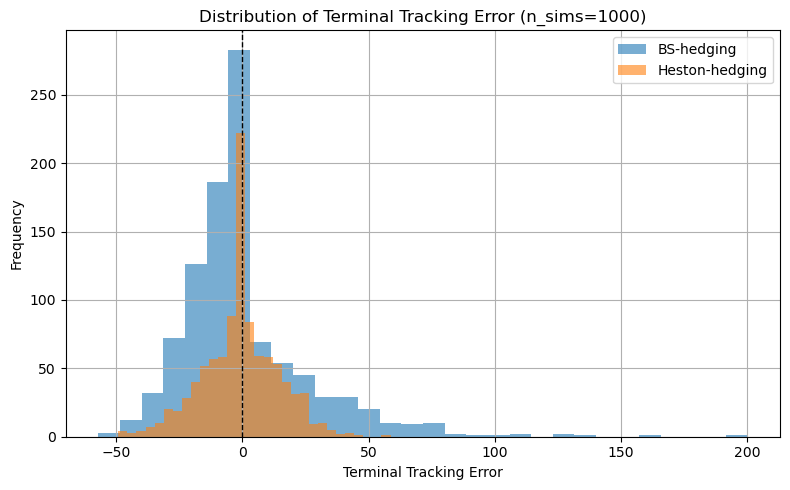

BS hedging    : mean = 0.3898, std = 25.7709
Heston hedging: mean = -0.7007, std = 14.9718


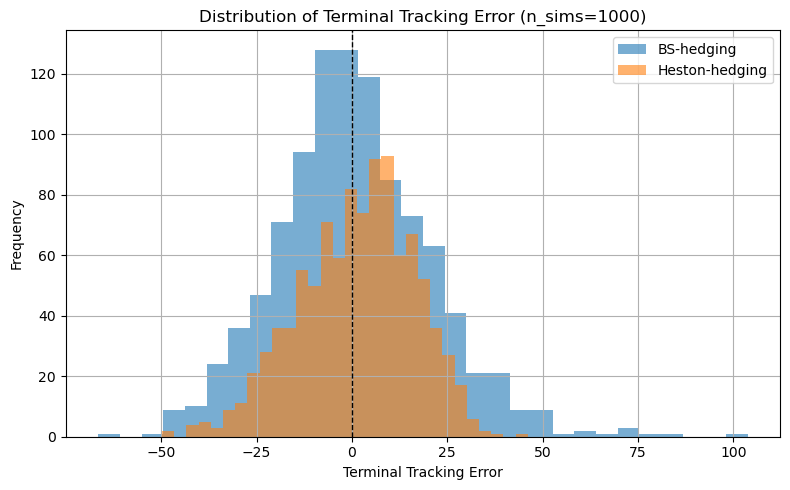

BS hedging    : mean = 0.5927, std = 20.2077
Heston hedging: mean = 1.2804, std = 15.0513


In [ ]:
def compute_tracking_error_path(
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    generatingModel="BS", hedgingModel="BS", dynamic=True
):
    """
    Exactly the same simulation logic as in plot_delta_tracking_error_over_time,
    but instead of plotting, we simply return the tracking_error array and the
    time grid t. You can then pick off the terminal error (tracking_error[-1])
    or analyze the entire path if you wish.
    """
    # 1) Simulate one “market” path under either BS or Heston
    if generatingModel == "BS":
        t, S_paths = simulate_bs_physical(
            S0, r, sigma_v,
            T=T, N_steps=N_steps, N_paths=1
        )
        S = S_paths[:, 0]
        # Under BS‐market, v is constant = v0
        v = np.full_like(S, v0)
    else:
        t, S_paths, v_paths = simulate_heston_physical(
            S0, v0, r, kappa, theta, sigma_v, rho,
            T=T, N_steps=N_steps, N_paths=1
        )
        S = S_paths[:, 0]
        v = v_paths[:, 0]

    # 2) Simulate the delta‐hedged portfolio along the same grid:
    if hedgingModel == "BS":
        t_h, S_h, delta_path, cash_path, portfolio = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol, "BS", dynamic=dynamic
        )
    elif hedgingModel == "Heston":
        t_h, S_h, delta_path, cash_path, portfolio = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol, "Heston", dynamic=dynamic
        )
    else:
        raise ValueError(f"Hedging model '{hedgingModel}' not recognized.")

    # 3) Compute Heston‐approximate call price at each time t[i]
    call_price_path = np.zeros_like(S)
    for i in range(len(t)):
        call_price_path[i] = heston_price_approx(
            S[i], K, r, T - t[i], v[i],
            theta, kappa, sigma_v, rho
        )[0]  # [0] since heston_price_approx returns (price, …)

    # 4) Tracking error = portfolio − Heston‐price
    tracking_error = portfolio - call_price_path

    # Return both the time grid and the tracking‐error path
    return t, tracking_error



def run_multiple_tracking_errors(
    n_sims,
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    generatingModel="BS", dynamic=True
):
    """
    Run `n_sims` independent simulations of the tracking error under:
      (a) BS‐hedging
      (b) Heston‐hedging

    We return two numpy arrays of shape (n_sims,), each containing the
    *terminal* tracking error (i.e. tracking_error at t = T) for each run.
    If you instead want the full paths, you could store the entire vector each time.

    Arguments:
      - n_sims           : how many Monte Carlo runs (e.g. 200).
      - S0, v0, r, …      : Heston/BS parameters as before.
      - generatingModel  : “BS” or “Heston” (which “market” process to simulate).
      - dynamic          : True/False for dynamic vs. static re‐hedging.
    """
    # Arrays to hold final‐time tracking errors
    te_bs_hedge      = np.zeros(n_sims)
    te_heston_hedge  = np.zeros(n_sims)

    for sim in range(n_sims):
        # (1) BS‐hedge run:
        _, te_path_bs = compute_tracking_error_path(
            S0, v0, r, theta, kappa, sigma_v, rho,
            K, T, N_steps, BS_implied_vol,
            generatingModel=generatingModel,
            hedgingModel="BS",
            dynamic=dynamic
        )
        te_bs_hedge[sim] = te_path_bs[-1]

        # (2) Heston‐hedge run:
        _, te_path_h = compute_tracking_error_path(
            S0, v0, r, theta, kappa, sigma_v, rho,
            K, T, N_steps, BS_implied_vol,
            generatingModel=generatingModel,
            hedgingModel="Heston",
            dynamic=dynamic
        )
        te_heston_hedge[sim] = te_path_h[-1]

    return te_bs_hedge, te_heston_hedge



# ----------------------------------------------------------------
# Example usage: compare distributions for 1000 sims
# ----------------------------------------------------------------

# (1) Set all model parameters:
S0 = 100.0
v0 = 0.04
r = 0.01
theta   = 0.04
kappa   = 1.5
sigma_v = 0.3
rho     = -0.7

K = 100.0
T = 1.0        # one‐year maturity
N_steps = 252  # daily re‐hedging
BS_implied_vol = 0.20

# Number of Monte Carlo runs:
n_sims = 1000

# (2) Run the n_sims simulations and collect terminal tracking errors:
te_bs, te_heston = run_multiple_tracking_errors(
    n_sims,
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    generatingModel="Heston",   # assume the “true” market is Heston
    dynamic=True               # dynamic delta re‐hedging
)

# (3) Plot histograms of the terminal tracking errors:
plt.figure(figsize=(8,5))
plt.hist(te_bs, bins=30, alpha=0.6, label="BS-hedging")
plt.hist(te_heston, bins=30, alpha=0.6, label="Heston-hedging")
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Terminal Tracking Error")
plt.ylabel("Frequency")
plt.title(f"Distribution of Terminal Tracking Error (n_sims={n_sims})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# (4) Print a quick summary (mean, std) of each distribution
print("BS hedging    : mean = {:.4f}, std = {:.4f}".format(
    np.mean(te_bs), np.std(te_bs)))
print("Heston hedging: mean = {:.4f}, std = {:.4f}".format(
    np.mean(te_heston), np.std(te_heston)))

# (2) Run the 200 simulations and collect terminal tracking errors:
te_bs, te_heston = run_multiple_tracking_errors(
    n_sims,
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    generatingModel="Heston",   # assume the “true” market is Heston
    dynamic=False               # dynamic delta re‐hedging
)

# (3) Plot histograms of the terminal tracking errors:
plt.figure(figsize=(8,5))
plt.hist(te_bs, bins=30, alpha=0.6, label="BS-hedging")
plt.hist(te_heston, bins=30, alpha=0.6, label="Heston-hedging")
plt.axvline(0, color="black", linestyle="--", linewidth=1)
plt.xlabel("Terminal Tracking Error")
plt.ylabel("Frequency")
plt.title(f"Distribution of Terminal Tracking Error (n_sims={n_sims})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# (4) Print a quick summary (mean, std) of each distribution
print("BS hedging    : mean = {:.4f}, std = {:.4f}".format(
    np.mean(te_bs), np.std(te_bs)))
print("Heston hedging: mean = {:.4f}, std = {:.4f}".format(
    np.mean(te_heston), np.std(te_heston)))


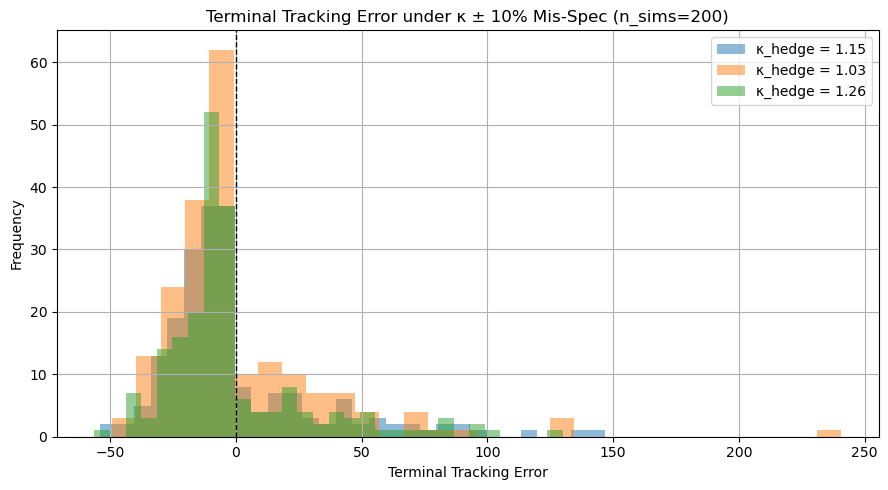

Nominal κ:     mean = -0.4008, std = 32.0468
κ_low  (−10%): mean = 0.9100, std = 33.8537
κ_high (+10%): mean = -1.2167, std = 28.7360


In [35]:
def run_heston_misparam_multiple(
    n_sims,
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    dynamic=True, mis_pct=0.10
):
    """
    Run n_sims Monte Carlo experiments to measure terminal tracking error 
    under three Heston‐hedging schemes:
      1) κ_hedge = κ (true parameter)
      2) κ_hedge = κ * (1 − mis_pct)
      3) κ_hedge = κ * (1 + mis_pct)

    For each simulation:
      a) Simulate one “true” Heston path using κ.
      b) Compute the Heston‐approximate call price along that path.
      c) For each κ_hedge ∈ {κ, κ±10%}, simulate a delta‐hedged portfolio under “Heston” 
         with that κ_hedge and record the terminal portfolio value.
      d) Terminal tracking error = portfolio(T) − call_price_true(T).

    Returns three arrays of length n_sims:
      te_nominal[i], te_low[i], te_high[i]
    """
    te_nominal = np.zeros(n_sims)
    te_low     = np.zeros(n_sims)
    te_high    = np.zeros(n_sims)

    kappa_low  = kappa * (1.0 - mis_pct)
    kappa_high = kappa * (1.0 + mis_pct)

    for i in range(n_sims):
        # --- (a) Simulate “true” Heston market path under κ ----------
        t, S_paths, v_paths = simulate_heston_physical(
            S0, v0, r, kappa, theta, sigma_v, rho,
            T=T, N_steps=N_steps, N_paths=1
        )
        S_true = S_paths[:, 0]
        v_true = v_paths[:, 0]

        # --- (b) Compute “true” Heston‐approximate call price along that path ---
        call_price_path = np.zeros_like(S_true)
        for j in range(len(t)):
            call_price_path[j] = heston_price_approx(
                S_true[j], 
                K, 
                r, 
                T - t[j], 
                v_true[j], 
                theta, 
                kappa, 
                sigma_v, 
                rho
            )[0]

        # --- (c1) Hedge with κ_hedge = κ (nominal) -------------------
        _, _, _, _, portfolio_nom = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol,
            Hedgingmodel="Heston",
            dynamic=dynamic
        )
        te_nominal[i] = portfolio_nom[-1] - call_price_path[-1]

        # --- (c2) Hedge with κ_hedge = κ_low -------------------------
        _, _, _, _, portfolio_low = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa_low, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol,
            Hedgingmodel="Heston",
            dynamic=dynamic
        )
        te_low[i] = portfolio_low[-1] - call_price_path[-1]

        # --- (c3) Hedge with κ_hedge = κ_high ------------------------
        _, _, _, _, portfolio_high = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa_high, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol,
            Hedgingmodel="Heston",
            dynamic=dynamic
        )
        te_high[i] = portfolio_high[-1] - call_price_path[-1]

    return te_nominal, te_low, te_high


# ------------------------------
# Example usage (200 simulations)
# ------------------------------
if __name__ == "__main__":
    # (1) Model parameters (true):
    S0      = 100.0
    v0      = 0.04
    r       = 0.01
    theta   = 0.035
    kappa   = 1.15
    sigma_v = 0.39
    rho     = -0.64

    # (2) Option & grid:
    K              = 100.0
    T              = 1.0
    N_steps        = 252
    BS_implied_vol = 0.20

    # (3) Number of Monte Carlo runs:
    n_sims = 200

    # (4) Run simulations:
    te_nom, te_low, te_high = run_heston_misparam_multiple(
        n_sims,
        S0, v0, r, theta, kappa, sigma_v, rho,
        K, T, N_steps, BS_implied_vol,
        dynamic=True,
        mis_pct=0.10
    )

    # (5) Plot histograms of terminal tracking errors:
    plt.figure(figsize=(9, 5))
    plt.hist(te_nom, bins=30, alpha=0.5, label=f"κ_hedge = {kappa:.2f}")
    plt.hist(te_low, bins=30, alpha=0.5, label=f"κ_hedge = {kappa*(1-0.10):.2f}")
    plt.hist(te_high, bins=30, alpha=0.5, label=f"κ_hedge = {kappa*(1+0.10):.2f}")
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.xlabel("Terminal Tracking Error")
    plt.ylabel("Frequency")
    plt.title(f"Terminal Tracking Error under κ ± 10% Mis‐Spec (n_sims={n_sims})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # (6) Print summary statistics:
    print("Nominal κ:     mean = {:.4f}, std = {:.4f}".format(np.mean(te_nom), np.std(te_nom)))
    print("κ_low  (−10%): mean = {:.4f}, std = {:.4f}".format(np.mean(te_low), np.std(te_low)))
    print("κ_high (+10%): mean = {:.4f}, std = {:.4f}".format(np.mean(te_high), np.std(te_high)))


In [ ]:
def run_heston_parameter_misparam(
    n_sims,
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    mis_params,
    generatingModel="Heston",
    dynamic=True
):
    """
    Run n_sims Monte Carlo experiments to measure terminal tracking error under Heston‐hedging,
    where you can specify arbitrary Heston parameters to mis‐approximate (± a given percentage).

    Arguments:
      - n_sims (int):
            Number of Monte Carlo runs.
      - S0, v0, r, theta, kappa, sigma_v, rho:
            “True” Heston parameters used to simulate the market (and to price the reference call).
      - K, T, N_steps, BS_implied_vol:
            Option strike, maturity, number of hedging steps, and the (constant) BS implied vol
            used in the hedging routine.
      - mis_params (dict):
            A dictionary whose keys are names of Heston parameters to mis‐approximate, and whose
            values are the fraction by which to perturb.  For example:
                mis_params = {
                   'kappa': 0.10,
                   'theta': 0.20,
                   'sigma_v': 0.15
                }
            means we will test:
              • κ_hedge = κ * (1 − 0.10)  and κ * (1 + 0.10)
              • θ_hedge = θ * (1 − 0.20)  and θ * (1 + 0.20)
              • σ_v_hedge = σ_v * (1 − 0.15) and σ_v * (1 + 0.15)
            keeping all other parameters at their “true” values in each scenario.
      - generatingModel (str, default="Heston"):
            Which model to simulate the “true” market under.  Typically "Heston".  Could also be
            "BS" if you want a BS “market” instead.
      - dynamic (bool, default=True):
            If True, use dynamic re‐hedging in simulate_delta_hedged_portfolio.  If False, do a
            static (one‐time) hedge.

    Returns:
      A dictionary mapping scenario names → numpy arrays of length n_sims:
        {
          'nominal':          array of terminal tracking errors (no mis‐spec),
          'kappa_low':        array of terminal tracking errors with κ_hedge = κ*(1−mis_pct_kappa),
          'kappa_high':       array of terminal tracking errors with κ_hedge = κ*(1+mis_pct_kappa),
          'theta_low':        array with θ_hedge = θ*(1−mis_pct_theta),
          'theta_high':       array with θ_hedge = θ*(1+mis_pct_theta),
          'sigma_v_low':      array with σ_v_hedge = σ_v*(1−mis_pct_sigma_v),
          'sigma_v_high':     array with σ_v_hedge = σ_v*(1+mis_pct_sigma_v),
          'rho_low':          array with ρ_hedge = ρ*(1−mis_pct_rho),
          'rho_high':         array with ρ_hedge = ρ*(1+mis_pct_rho),
          'v0_low':           array with v0_hedge = v0*(1−mis_pct_v0),
          'v0_high':          array with v0_hedge = v0*(1+mis_pct_v0),
          ...
        }
      Only parameters present in mis_params will appear (each with a "_low" and "_high" array).
      Always includes 'nominal'.

    How it works:
      1) For each sim, we generate one “true” Heston‐market path (unless generatingModel="BS").
      2) We compute the “true” Heston‐approximate call price path along that simulated market path.
      3) We run a delta‐hedged portfolio under “Heston” with each mis‐specified parameter in turn
         (only one mis‐spec at a time—others remain at their true values).  For each scenario,
         we record the terminal portfolio value.
      4) Terminal tracking error = portfolio(T) − call_price_true(T).
    """
    # Prepare output arrays
    results = {}
    results['nominal'] = np.zeros(n_sims)

    # For each parameter the user wants to mis‐specify, set up two arrays: low/high
    for param, pct in mis_params.items():
        low_key  = f"{param}_low"
        high_key = f"{param}_high"
        results[low_key]  = np.zeros(n_sims)
        results[high_key] = np.zeros(n_sims)

    # Put the “true” parameters in a dict so we can easily replace one at a time
    true_params = {
        'v0':      v0,
        'kappa':   kappa,
        'theta':   theta,
        'sigma_v': sigma_v,
        'rho':     rho
    }

    for i in range(n_sims):
        # 1) Simulate one “true” market path under generatingModel
        if generatingModel == "BS":
            t, S_paths = simulate_bs_physical(
                S0, r, sigma_v,  # BS uses sigma_v as constant vol
                T=T, N_steps=N_steps, N_paths=1
            )
            S_true = S_paths[:, 0]
            v_true = np.full_like(S_true, v0)
        else:  # generatingModel == "Heston"
            t, S_paths, v_paths = simulate_heston_physical(
                S0, v0, r, kappa, theta, sigma_v, rho,
                T=T, N_steps=N_steps, N_paths=1
            )
            S_true = S_paths[:, 0]
            v_true = v_paths[:, 0]

        # 2) Compute the “true” Heston‐approximate call price along the entire path
        call_price_path = np.zeros_like(S_true)
        for j in range(len(t)):
            call_price_path[j] = heston_price_approx(
                S_true[j],
                K,
                r,
                T - t[j],
                v_true[j],
                theta,
                kappa,
                sigma_v,
                rho
            )[0]

        # 3a) Baseline: Heston‐hedge with the true parameters
        _, _, _, _, portfolio_nom = simulate_delta_hedged_portfolio(
            S0, v0, r, kappa, theta, sigma_v, rho,
            K, T, N_steps, BS_implied_vol,
            Hedgingmodel="Heston",
            dynamic=dynamic
        )
        results['nominal'][i] = portfolio_nom[-1] - call_price_path[-1]

        # 3b) For each parameter in mis_params, do “−pct” and “+pct”
        for param, pct in mis_params.items():
            base_val = true_params[param]
            low_val  = base_val * (1.0 - pct)
            high_val = base_val * (1.0 + pct)

            # Copy true_params so we only override one at a time
            hedge_low_params  = true_params.copy()
            hedge_high_params = true_params.copy()

            hedge_low_params[param]  = low_val
            hedge_high_params[param] = high_val

            # Extract for calling simulate_delta_hedged_portfolio
            v0_h_low  = hedge_low_params['v0']
            kappa_h_low = hedge_low_params['kappa']
            theta_h_low = hedge_low_params['theta']
            sigma_v_h_low = hedge_low_params['sigma_v']
            rho_h_low  = hedge_low_params['rho']

            v0_h_high  = hedge_high_params['v0']
            kappa_h_high = hedge_high_params['kappa']
            theta_h_high = hedge_high_params['theta']
            sigma_v_h_high = hedge_high_params['sigma_v']
            rho_h_high  = hedge_high_params['rho']

            # Hedging with the “low” variant
            _, _, _, _, portfolio_low = simulate_delta_hedged_portfolio(
                S0, 
                v0_h_low, 
                r, 
                kappa_h_low, 
                theta_h_low, 
                sigma_v_h_low, 
                rho_h_low,
                K, T, N_steps, BS_implied_vol,
                Hedgingmodel="Heston",
                dynamic=dynamic
            )
            results[f"{param}_low"][i] = portfolio_low[-1] - call_price_path[-1]

            # Hedging with the “high” variant
            _, _, _, _, portfolio_high = simulate_delta_hedged_portfolio(
                S0, 
                v0_h_high, 
                r, 
                kappa_h_high, 
                theta_h_high, 
                sigma_v_h_high, 
                rho_h_high,
                K, T, N_steps, BS_implied_vol,
                Hedgingmodel="Heston",
                dynamic=dynamic
            )
            results[f"{param}_high"][i] = portfolio_high[-1] - call_price_path[-1]

    return results


In [ ]:

# (1) True Heston parameters
S0      = 100.0
v0      = 0.04
r       = 0.01
theta   = 0.04
kappa   = 1.5
sigma_v = 0.3
rho     = -0.7

# (2) Option specs & grid
K              = 100.0
T              = 1.0
N_steps        = 252
BS_implied_vol = 0.20

# (3) Specify which parameters to mis‐approximate and by how much:
mis_params = {
    'kappa':   0.10,  # test ±10% error in kappa
    'theta':   0.20,  # test ±20% error in theta
    'sigma_v': 0.15   # test ±15% error in sigma_v
    # you could also add 'rho': 0.05 or 'v0': 0.10, etc.
}

# (4) Run 200 simulations:
n_sims = 200
results = run_heston_parameter_misparam(
    n_sims,
    S0, v0, r, theta, kappa, sigma_v, rho,
    K, T, N_steps, BS_implied_vol,
    mis_params,
    generatingModel="Heston",
    dynamic=True
)

# (5) Now results is a dict with keys:
#     'nominal', 'kappa_low', 'kappa_high', 'theta_low', 'theta_high',
#     'sigma_v_low', 'sigma_v_high', ... 
#     Each maps to a length‐n_sims array of terminal tracking errors.

# Example: plot histograms for κ mis‐spec only
plt.figure(figsize=(8,5))
plt.hist(results['nominal'],   bins=30, alpha=0.5, label="κ = true")
plt.hist(results['kappa_low'], bins=30, alpha=0.5, label=f"κ = {kappa*(1-0.10):.2f}")
plt.hist(results['kappa_high'],bins=30, alpha=0.5, label=f"κ = {kappa*(1+0.10):.2f}")
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Terminal Tracking Error")
plt.ylabel("Frequency")
plt.title("Sensitivity to ±10% Mis‐specification of κ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Example: summary stats for θ mis‐spec
theta_low  = np.mean(results['theta_low']),  np.std(results['theta_low'])
theta_nominal = np.mean(results['nominal']),  np.std(results['nominal'])
theta_high = np.mean(results['theta_high']), np.std(results['theta_high'])
print(f"θ _low  (−20%): mean = {theta_low[0]:.4f}, std = {theta_low[1]:.4f}")
print(f"θ nominal  : mean = {theta_nominal[0]:.4f}, std = {theta_nominal[1]:.4f}")                                                             
print(f"θ _high (+20%): mean = {theta_high[0]:.4f}, std = {theta_high[1]:.4f}")

theta_low  = np.mean(results['sigma_v_low']),  np.std(results['sigma_v_low'])
theta_nominal = np.mean(results['nominal']),  np.std(results['nominal'])
theta_high = np.mean(results['sigma_v_high']), np.std(results['sigma_v_high'])
print(f"θ _low  (−20%): mean = {theta_low[0]:.4f}, std = {theta_low[1]:.4f}")
print(f"θ nominal  : mean = {theta_nominal[0]:.4f}, std = {theta_nominal[1]:.4f}")                                                             
print(f"θ _high (+20%): mean = {theta_high[0]:.4f}, std = {theta_high[1]:.4f}")
